# Image Analysis 1: Colocalisation
## 1. Preparation
### 1.1 Loading Packages
The following packages are used in the whole algorithm:

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import nd2
import cc3d
import pickle

from scipy import signal
from scipy import stats
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

from skimage.util import img_as_float, img_as_int
from skimage.feature import peak_local_max
from skimage import filters

from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import morphology
from skimage.filters import threshold_multiotsu, threshold_otsu, sobel
from skimage.segmentation import watershed, expand_labels, mark_boundaries, clear_border
from skimage.filters import rank, laplace, gaussian
from skimage.measure import regionprops, regionprops_table
from skimage import measure
from skimage import restoration
from skimage.exposure import rescale_intensity
from skimage.draw import disk

The following functions and parameters are used for testing the individual functions:

In [2]:
def getimfolder(experiment):
    import os
    basedir = ""
    data = "E:\Raphael\Data"
    for folder in os.listdir(data):
        if str(experiment) in folder:
            basedir = os.path.join(data, folder)
    return basedir

experiment = 3
rep = 1
PID = 0
NDID = 0
stack = 0
Group1 = "FY"
Group2 = "LAMP1"
Channel1 = "DAPI"
Channel2 = "GFP"
Channel3 = "568_2"

basedir = getimfolder(experiment)
imagedir = os.path.join(basedir, "Images")
maskdir = os.path.join(basedir, "Masks_Cells")
info = os.path.join(basedir, "Info.xlsx")
#idf = pd.read_excel(info)

The following function implements plotting of the images for comparison

In [3]:
def plottest(images, titles):
    nimage = len(images)
    fig, axes = plt.subplots(ncols=nimage, figsize=(3*nimage, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(nimage):
        ax[i].imshow(images[i])
        ax[i].set_title(titles[i])
        ax[i].set_axis_off()
    fig.tight_layout()
    return ax

## 2. Loading images
The "ND-Aquire" feature in the NIS-Software produces a 5-Dimensional "Image":
- Dimension 0 stores the image "series" meaning every individual image from the multipoint Aquisition
- DImension 1 stores the stack from the Z-Stack aquisition
- Dimension 2 stores the channel
- Dimesion 3 and 4 store the images in the x and y direction

The following functions will implement a way of seperationg each series and stack and to just store each indvidual 2d image seperately. Every one of these get their own "ID" and are stored in the "Images" folder by the convention "ID.tif". A seperate CSV file is created storing all the relevant information for each image.
- PID: each series gets its own ID; resets after every file
- Stack: number of the stack; resets after every series
- CHannel: CHannels as  described by the microscope
- xlen, ylen,zlen: pixelsize as recorded by the microscope
- Group1: X, TP or FY
- Group2: LAMP1 or LC3
- NDID: each image gets its own ID while ignoring the channels; this can identify which 3 individual images belong together even though they have 3 different channels and therefore different IDs



In [4]:
def readimages(rawdir, splitdir, ID, NDID,rep):
    import os
    import tifffile as tiff
    import nd2
    data = {"ID":[], "PID":[], "Channel": [], "ChID": [], "xlen": [], "ylen":[], "zlen": [], "Group1":[], "Group2":[], "NDID":[],"Rep":[]}
    for ndimg in os.listdir(rawdir):
        if "Deconvolved" in ndimg:
            PID = 0
            iml = os.path.join(rawdir, ndimg)
            with nd2.ND2File(iml) as ndfile:
                meta = ndfile.metadata
                shape = ndfile.shape
                for series in range(shape[0]):
                    for i in range(len(meta.channels)):
                        chan = meta.channels[i].channel.name
                        ch = ""
                        if chan in ["647"]:
                            ch = "aSyn_AB"
                        elif chan in ["DAPI"]:
                            ch = "DAPI"
                        elif chan in ["GFP"]:
                            ch = "aSyn_GFP"
                        elif chan in ["568_2", "uAlexa555_1"]:
                            ch = ndimg.split("_")[1].split(" ")[0]
                        else:
                            continue
                        #img = ndfile.asarray(PID)
                        #img = img[:,:,i,:,:]
                        #tiff.imwrite(os.path.join(splitdir,str(ID))+".tif", img)
                        xlen, ylen, zlen = meta.channels[i].volume.axesCalibration
                        data["ID"].append(str(ID))
                        data["PID"].append(str(PID))
                        data["NDID"].append(NDID)
                        data["Channel"].append(str(ch))
                        data["ChID"].append(i)
                        data["xlen"].append(xlen)
                        data["ylen"].append(ylen)
                        data["zlen"].append(zlen)
                        data["Group1"].append(ndimg.split("_")[0])
                        data["Group2"].append(ndimg.split("_")[1].split(" ")[0])
                        data["Rep"].append(rep)

                        ID = ID+1
                    NDID+=1
                    PID = PID+1
    return data

def splitimages(experiment, rep):
    import os
    import pandas as pd
    basedir = getimfolder(experiment)
    rawdir = os.path.join(basedir,str(rep))
    splitdir = os.path.join(basedir,"Images")
    info = os.path.join(basedir, "Info.xlsx")
    if os.path.exists(info) == True:
        old_df = pd.read_excel(info)
        ID = max(old_df["ID"])
        NDID = max(old_df["NDID"])
        data = readimages(rawdir, splitdir, ID, NDID,rep)
        new_df = pd.DataFrame(data = data)
        print(len(new_df))
        df = pd.concat([old_df,new_df])
        df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
    else:
        ID = 0
        data = readimages(rawdir, splitdir, ID, 0,rep)
        df = pd.DataFrame(data = data)
        print(len(df))
        df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
    df.to_excel(info,index=False)
    


To extract the exact ID in the future the following function is implemented to search the created dataframe

In [5]:
def getImage(df, ID, basedir):
    imdir = os.path.join(basedir, str(df["Rep"][df["ID"]==ID].values[0]))
    string = str(df["Group1"][df["ID"]==ID].values[0])+"_"+str(df["Group2"][df["ID"]==ID].values[0])+" - Deconvolved"
    for ndimg in os.listdir(imdir):
        if string in ndimg:
            iml = os.path.join(imdir,ndimg)
            with nd2.ND2File(iml) as ndfile:
                print(ndfile)
                img = ndfile.to_dask(df["PID"][df["ID"]==ID].values[0])
                i = df["ChID"][df["ID"]==ID].values[0]
                img = img[0,:,i,:,:]
                img = np.array(img)
                return img



In [6]:
def get_ripley_ALL(basedir, max_r):
    sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
    cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
    maxID = 0
    IDs = cdf["CID"].unique()
    if os.path.exists(os.path.join(basedir, "Ripley.csv")) == True:
        rdf = pd.read_csv(os.path.join(basedir, "Ripley.csv"))
        maxID = rdf["CID"].max()
        IDs = cdf["CID"][cdf["CID"]>maxID].unique()
        print("Already done:")
        print(cdf["CID"][cdf["CID"]<=maxID].unique())
    max_ind = cdf.index.max()
    for CID in IDs:
        print(str(cdf.index[cdf["CID"]==CID][0])+"/"+str(max_ind)+": Started")
        rdf_new = get_ripley_cell(sdf,cdf, CID, basedir, max_r)
        if os.path.exists(os.path.join(basedir, "Ripley.csv")) == True:
            rdf_old = pd.read_csv(os.path.join(basedir, "Ripley.csv"))
            rdf_save = pd.concat([rdf_old,rdf_new])
            rdf_save.to_csv(os.path.join(basedir, "Ripley.csv"))
        rdf_new.to_csv(os.path.join(basedir, "Ripley.csv"))
        print(str(cdf.index[cdf["CID"]==CID][0])+"/"+str(max_ind)+": Completed")
    return

get_ripley_ALL(basedir, max_r)

NameError: name 'max_r' is not defined

## 3. Image segmentation
### 3.1 Segmenting Nuclei
The nuclei are segmented by using the "StarDist" NeuralNetwork which tries to find "Star-convex" structures, for example cell nuclei. Thankfully the network has been pretrained by the developers by using celles stained with DAPI. The folowing functions will implement the segmentation of the nuclei, which are passed to the algorithm which automatically labels the structures. Since the images used are of much higher resolution than the images used in training the images have to be first downscaled ("rescale_before") and the upscaled ("rescale_after") to match the original size.
Firstly the model is loaded:

In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Afterwards the functions are implemented:

In [ ]:
def rescale_before(img, pixlenimg):
    from skimage.transform import rescale
    pixlensd = 0.3488
    scaling_factor = pixlenimg/pixlensd
    image_rescaled = rescale(img, scaling_factor, anti_aliasing=True)
    return image_rescaled

def rescale_after(img, dims):
    from skimage.transform import resize
    image_resized = resize(img, dims, preserve_range=True, order=0, anti_aliasing=False).astype('uint8')
    return image_resized

def segment_nuclei_slice(img,xlen, model):
    if model == None:
        model = StarDist2D.from_pretrained('2D_versatile_fluo')
    img_rescaled = rescale_before(img, xlen)
    labelssd, _ = model.predict_instances(normalize(img_rescaled))
    labels_rescaled = rescale_after(labelssd, img.shape)
    return labels_rescaled

def realign_labels(lab_stack):
    maxl = np.max(lab_stack[0,:,:])
    for i in range(1,lab_stack.shape[0]):
        props = regionprops(lab_stack[i,:,:])
        for j in range(len(props)):
            c = np.round(props[j].centroid)
            l = props[j].label
            area = props[j].area
            if area < 10000:
                lab_stack[i,:,:][lab_stack[i,:,:]==l] = 0
            elif lab_stack[i-1,int(c[1]),int(c[0])] == 0:
                maxl = maxl+1
                print(maxl)
                lab_stack[i,:,:][lab_stack[i,:,:]==l] = maxl
            else:
                lab_stack[i,:,:][lab_stack[i,:,:]==l] = lab_stack[i-1,int(c[1]),int(c[0])]
    return lab_stack

def segment_nuclei_stack(df,ID, model, basedir):
    print("beforegetimage")
    img = getImage(df, ID, basedir)
    print("aftergetimage")
    lab_stack = np.zeros(img.shape, dtype = np.uint8)
    xlen = df["xlen"][df["ID"]==ID].values[0]
    max_l = 1
    for stack in range(img.shape[0]):
        print("beforesegslice")
        labels = segment_nuclei_slice(img[stack,:,:], xlen, model)
        props = regionprops(labels)
        for i in range(len(props)):
            l = props[i].label
            area = props[i].area
            if area < 10000:
                labels[labels==l] = 0
        labels = labels + max_l
        labels[labels == max_l] = 0
        max_l = np.max(labels)

        lab_stack[stack,:,:] = labels
    return lab_stack, img
    


As can be seen the algorithm does a good job in segmenting the cells. Some small puncta are identified as cells but these will be eliminated later. All out of focus nuclei will be eliminated as well.

### 3.2 Segmenting cells
Starting from the nuclei the cells are identified. This is done by the clssic technique of first thresholding and then Watershedding to segment the cells. Since cells are all illuminated differently, a multi-otso threshholding algorithm is apllied. Afterwards watershedding is applied to each threshhold one by one starting from the highest. THsi gives precedence to brighter cells.

In [ ]:
def first_segmentation(img, labels_rescaled):
    if len(np.unique(img)) < 3:
        return "EXIT"
    thresholds = threshold_multiotsu(img)
    thresholds[::-1].sort()
    labeled = labels_rescaled
    for t in thresholds:
        binary = img >= t
        binary[labeled != 0] = True
        labeled = watershed(-img, markers = labeled, mask = binary)
    return labeled



In the first segmentation step the algorithm will slightly overestimate the size of bright cells. Furthermore most cells are quite dim and their percieved size (green) is not different from that of the nucleus (yellow). These cells will be eliminated later. 


Afterwards a second segmentation step is applied to estimate the boundary of the cells more precisely:
First the bounding box is calculated for each label and then cropped to have an image just of the individual cell. Afterwards the image is thresholded again and watershedding is applied between the original background and the new threshhold using an image created by applying a sobe filter as boundaries.

Firstly a function is created that crops an image:

In [ ]:
def crop(image, label, df):
    r = df[df["label"] == label]
    cimage = image[int(r["bbox-0"].values):int(r["bbox-2"].values),int(r["bbox-1"].values):int(r["bbox-3"].values)]
    return cimage

def reversecrop(zeros, insert, label, df):
    r = df[df["label"] == label]
    zeros[int(r["bbox-0"].values):int(r["bbox-2"].values),int(r["bbox-1"].values):int(r["bbox-3"].values)] = insert
    return zeros


Secondly the segementing function is implemented:

In [ ]:
def second_segmentation(img, labeled):
    tempprops =  measure.regionprops_table(labeled, img, properties=['label', 'bbox','intensity_mean'])
    finallabel = np.zeros(labeled.shape, dtype = np.uint8)
    propdf = pd.DataFrame(tempprops)
    propdf = propdf.sort_values(by=['intensity_mean'], ascending=False)
    LLabel = propdf.loc[:,"label"].values
    for i in range(len(LLabel)):
        l = LLabel[i]
        mask_crop = crop(labeled, l, propdf)
        cropped = crop(img, l, propdf)
        t = threshold_multiotsu(cropped)
        labels = np.zeros(mask_crop.shape)
        labels[mask_crop == l] = 0
        labels[cropped > t[0]] = l
        labels[mask_crop != l] = l+1
        elevation_map = sobel(cropped)
        seg = watershed(elevation_map, labels)
        seg[seg == l+1] = 0
        segup = np.zeros(finallabel.shape, dtype = np.uint8)
        segup = reversecrop(segup, seg, l, propdf)
        segup[finallabel > 0] = 0
        finallabel = finallabel + segup
    return finallabel



This results in some nuclei being cut in the wrong way so the nuclei map is broadcasted over:

In [ ]:
def addnuclei(labeledcells, labelednuclei):
    addition = labeledcells
    addition[labelednuclei > 0] = 0
    addition += labelednuclei
    return addition



This now perfects the segmentation. All dim cells now have 0 cytoplasmic area and are therefore easy to identify by calculationg the nucleus:cytoplasm ratio.

Now all edge labels are removed:

In [ ]:
def remove_edges(celllabel, nucleilabel):
    necells = clear_border(celllabel)
    necells = morphology.remove_small_objects(necells, 64)
    nenuclei = nucleilabel
    for l in np.unique(nucleilabel):
        if l not in np.unique(necells):
            nenuclei[nenuclei == l] = 0
    return necells, nenuclei



In [ ]:
def segment_stack(df, IDN, model, basedir):
    labels_nuclei, DAPI = segment_nuclei_stack(df,IDN, model, basedir)
    GFP = getImage(df, IDN-2, basedir)
    Ln = np.zeros(labels_nuclei.shape, dtype = np.uint8)
    Lc = np.zeros(GFP.shape, dtype = np.uint8)
    for i in range(GFP.shape[0]):
        first_seg = first_segmentation(np.array(GFP[i,:,:]), np.array(labels_nuclei[i,:,:]))
        if first_seg == "EXIT":
            return "EXIT", "EXIT"
        second_seg = second_segmentation(np.array(GFP[i,:,:]), first_seg)
        final_seg = addnuclei(second_seg, np.array(labels_nuclei[i,:,:]))
        celllabel, nucleilabel = remove_edges(second_seg, np.array(labels_nuclei[i,:,:]))
        Ln[i,:,:] = nucleilabel
        Lc[i,:,:] = celllabel
    return Lc, Ln, GFP, DAPI



### 3.3 Measurement and saving
After segementing our cells and nuclei, their data needs to be measured and saved:
- CID: Every cell gets their own unique ID
- NDID: Identifies the image the segmentation was done on
- Label: Label of cells/nucleus in image
- Area, BoundingBox, Centroid and Mean Intensity are measured on GFP/DAPI images
- N:C value is calculcated by dividing the Area of the cell by the area of the nucleus
    - 1 means perfect overlap -> NO cytoplasm visible in GFP
    - This means the cell is untransfected -> these are removed
- Variation of Laplace is calculated to determine the focus

In [ ]:
def getvarLaplace(img, labeled_img, dfin):
    data = {"label":[],"Laplace_0":[],"Laplace_1":[],"Laplace_2":[],"Laplace_3":[],"Laplace_4":[],"Laplace_5":[],"Laplace_6":[],"Laplace_7":[],"Laplace_8":[],"Laplace_9":[],"Laplace_10":[]}
    for label in np.unique(labeled_img):
        if label == 0:
            continue
        binary = labeled_img == label
        for i in range(img.shape[0]):
            VarLap = laplace(img[i,:,:], mask = binary[i,:,:]).var()
            data["label"].append(label)
            data["Laplace_"+str(i)].append(VarLap)
    df = pd.DataFrame(data = data)
    dfout = dfin.merge(df, "left", on = "label")
    return dfout

def measure_cells(celllabel, nucleilabel, GFP, DAPI):
    cellprops = regionprops_table(np.array(celllabel), np.array(GFP), properties=['label', 'bbox','intensity_mean', "Area", "centroid"])
    dfc = pd.DataFrame(cellprops)
    #dfc = getvarLaplace(GFP, celllabel, dfc)
    nucleiprops = regionprops_table(np.array(nucleilabel), np.array(DAPI), properties=['label','intensity_mean', "Area", "centroid"])
    dfn = pd.DataFrame(nucleiprops)
    #dfn = getvarLaplace(DAPI, nucleilabel, dfn)
    df = dfc.merge(dfn, "inner", on = "label", suffixes = ("_cell","_nucleus"))
    df["N:C"] = df["Area_nucleus"]/df["Area_cell"]
    df["Include"] = True
    df = df.drop(df[df["N:C"] > 0.9].index)
    return df



As is apparent, only one cell survived the removal process, which is as expected.
Finally the dataframe is saved as an Excel File:

In [ ]:
def save_cells(new_df, basedir):
    cinfo = os.path.join(basedir, "CellInfo.csv")
    if os.path.exists(cinfo) == True:
        old_df = pd.read_csv(cinfo)
        if np.max(new_df["NDID"]) <= np.max(old_df["NDID"]):
              return cinfo
        oldID = max(old_df["CID"])
        new_df["CID"] = new_df["CID"]+oldID+1
        new_df = new_df.drop(new_df[new_df["NDID"] == max(old_df["NDID"])].index)
        cdf = pd.concat([old_df,new_df])
        cdf.to_csv(cinfo,index=False)
    else:
        new_df.to_csv(cinfo,index=False)
    return cinfo




Now that all functions are implemented, the can be strung together into another function that automates the whole process:

In [ ]:
def get_perimeter(Lc, Ln, df, basedir):
    boundaryC = expand_labels(Lc, distance = 1)
    boundaryC[Lc > 0] = 0
    propC = regionprops(boundaryC)
    dicC = {}
    for i in range(len(propC)):
        if int(propC[i].label) in df["label"].values:
            dicC[int(df["CID"][df["label"]==propC[i].label].values)] = propC[i].coords
    if os.path.exists(os.path.join(basedir,'cytoplasm.pickle')) == True:
        with open(os.path.join(basedir,'cytoplasm.pickle'), 'rb') as handle:
            dicC.update(pickle.load(handle))
    with open(os.path.join(basedir,'cytoplasm.pickle'), 'wb') as handle:
        pickle.dump(dicC, handle, protocol=pickle.HIGHEST_PROTOCOL)
    boundaryN = expand_labels(Ln, distance = 1)
    boundaryN[Ln > 0] = 0
    propN = regionprops(boundaryN)
    dicN = {}
    for i in range(len(propN)):
        if propN[i].label in df["label"].values:
            dicN[int(df["CID"][df["label"]==propN[i].label].values)] = propN[i].coords
    if os.path.exists(os.path.join(basedir,'nucleus.pickle')) == True:
        with open(os.path.join(basedir,'nucleus.pickle'), 'rb') as handle:
            dicN.update(pickle.load(handle))
    with open(os.path.join(basedir,'nucleus.pickle'), 'wb') as handle:
        pickle.dump(dicN, handle, protocol=pickle.HIGHEST_PROTOCOL)
    coordinfo = [os.path.join(basedir,'cytoplasm.pickle'),os.path.join(basedir,'nucleus.pickle')]
    return coordinfo



In [ ]:
def get_cytoplsam_coords(Lc, Ln, df, basedir):
    cellab = np.zeros(Lc.shape, dtype = np.uint8)
    cellab[:] = Lc
    cellab[Ln > 0] = 0
    prop = regionprops(cellab)
    dic = {}
    for i in range(len(prop)):
        if int(prop[i].label) in df["label"].values:
            dic[int(df["CID"][df["label"]==prop[i].label].values)] = prop[i].coords
    if os.path.exists(os.path.join(basedir,'sampling.pickle')) == True:
        with open(os.path.join(basedir,'sampling.pickle'), 'rb') as handle:
            dic.update(pickle.load(handle))
    with open(os.path.join(basedir,'sampling.pickle'), 'wb') as handle:
        pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return



In [ ]:
def segment_cells(idf, NDID, basedir, model):
    r = idf[idf["NDID"] == NDID]
    print(r)
    DAPI_ID = int(r["ID"][r["Channel"]=="DAPI"].values)
    print("before seg")
    Lc, Ln, GFP_img, DAPI_img = segment_stack(idf, DAPI_ID, model, basedir)
    if Lc == "EXIT":
        return "EXIT","EXIT","EXIT","EXIT"
    dfs = []
    for i in range(Lc.shape[0]):
        df = measure_cells(Lc[i,:,:], Ln[i,:,:], GFP_img[i,:,:], DAPI_img[i,:,:])
        df["NDID"] = NDID
        CID = df["label"].values
        df["CID"] = CID
        pinfo = get_perimeter(Lc[i,:,:], Ln[i,:,:],df, basedir)
        get_cytoplsam_coords(Lc[i,:,:], Ln[i,:,:],df, basedir)
        df["Stack"] = i
        dfs.append(df)
    cdf = pd.concat(dfs)
    cinfo = save_cells(cdf, basedir)
    return cinfo, pinfo, Lc, Ln




This concludes the segmentation process. Afterwards the cells will be looked at individually to extract points for colocalisation.

## 4. Point extraction
### Wavelet Transform
Spots are detected by using a Stationary Wavelet Transform. This algorithm convolves a kernel over the image and subtracts the result leaving the spots and all the noise. Afterwards zeros are inserted into the kerne and another convolution is performed, which improves the signal at the spots and reduces the noise. This step is repeated 4 times.

First the  starting kernel is defined:

In [ ]:
kernel = np.array([[1/16, 1/4, 3/8, 1/4, 1/16]])

Afterwards the function that changes the kernel is implemented:

In [ ]:
def createkernel(kernel, level):
    zeroc = (2**(level-1))-1
    nklen = kernel.shape[1] + (kernel.shape[1]-1)*zeroc
    new_kernel = np.zeros((1, nklen), dtype = kernel.dtype)
    for i in range(kernel.shape[1]):
        index = i + i*zeroc
        new_kernel[0][index] = kernel[0][i]
    return new_kernel



Now two functions are implemented, that perform the actual convolution:
"atrousconvolution" implements the convolution step and is called by "wavelet_dection" repeatedly until the maximum level is reached. THe final image P is returned:

In [ ]:
def atrousconvolution(image, P_old, level , og_kernel):
    kernel = createkernel(og_kernel, level)
    Ai = signal.convolve2d(image, kernel, boundary = "symm", mode = "same")
    A = signal.convolve2d(Ai, kernel.T, boundary = "symm", mode = "same")
    W = image - A
    t = 3*(stats.median_abs_deviation(W)/0.67)
    T = W
    T[T<t] = 0
    P = T*P_old
    return P, W

def wavelet_detection(image, og_kernel, max_level):
    level = 1
    P = np.ones(image.shape)
    cimage = image
    while level < max_level+1:
        cimage, P = atrousconvolution(image, P, level , og_kernel)
        level = level + 1
    return P



In [ ]:
def removestrangers(croppedimage, mask, label, dfC):
    cmask = crop(mask,label, dfC)
    cmask[cmask != label] = 0
    croppedimage[cmask == 0] = 0
    return croppedimage, cmask



In [ ]:
def remove_nucleus(croppedimage, mask, label, dfC):
    nmask = crop(mask,label, dfC)
    newimage = croppedimage
    newimage[nmask == label] = 0
    return newimage, nmask



This results in the algorithm wrongly classifying the edges as "Spots".

Spots on the enge get eliminated next:

In [ ]:
def eliminate_edgespots(timg, mask, label):
    exlabels = expand_labels(timg, distance = 6)
    exlabels[mask == label] = 0
    for l in np.unique(exlabels):
        if l == 0:
            continue
        else:
            timg[timg == l] = 0
    return timg



In [ ]:
def measurespots(label, intensity):
    props = regionprops_table(label, intensity, properties=['label', 'bbox','intensity_mean', "Area", "centroid", "perimeter"])
    df = pd.DataFrame(data = props)
    #df = getvarLaplace(intensity, expand_labels(label, distance = 4), df)
    df["Include"] = True
    return df


    

In [ ]:
def save_spots(new_df, basedir):
    sinfo = os.path.join(basedir, "SpotsInfo.csv")
    if os.path.exists(sinfo) == True:
        old_df = pd.read_csv(sinfo)
        oldID = max(old_df["SID"])
        new_df["SID"] = new_df["SID"]+oldID
        cdf = pd.concat([old_df,new_df])
        cdf.to_csv(sinfo,index=False)
    else:
        new_df.to_csv(sinfo,index=False)
    return sinfo

Next we will combine all the steps from before to extract spots from a whole stack of images:

In [ ]:
def extract_stack(img, CL, NL, NDID, kernel, cdf):
    dfs = []
    for i in range(img.shape[0]):
        sliced = img[i,:,:]
        sCL = CL[i,:,:]
        sNL = NL[i,:,:]
        for label in cdf["label"][cdf["NDID"]==NDID][cdf["Stack"]==i].unique():
            cropped = crop(sliced,label,cdf[cdf["NDID"]==NDID][cdf["Stack"]==i])
            spots1 = wavelet_detection(cropped, kernel, 4)
            spots2 = None
            spots2 = spots1 > threshold_otsu(spots1)
            spots2 = morphology.remove_small_objects(spots2, 20)
            spots2 = measure.label(spots2)
            spots3, cmask = removestrangers(spots2, sCL, label, cdf[cdf["NDID"]==NDID][cdf["Stack"]==i])
            spots4, nmask = remove_nucleus(spots3, sNL, label, cdf[cdf["NDID"]==NDID][cdf["Stack"]==i])
            spots5 = eliminate_edgespots(spots4, cmask, label)
            tdf = measurespots(spots5, cropped)
            CID = int(cdf["CID"][cdf["NDID"]==NDID][cdf["Stack"]==i][cdf["label"]==label].values)
            tdf["CID"] = CID
            tdf["SID"] = tdf["label"]
            dfs.append(tdf)
    if dfs != []:
        df = pd.concat(dfs, ignore_index = True)
        return df
    else:
        return pd.DataFrame({'A' : []})




Finally we will implement a function that takes in "NDID" as input and automatically segments the cells and extracts spots:

In [ ]:
def extract_spots(idf, NDID, basedir, model):
    if os.path.exists(os.path.join(basedir, "CellInfo.csv")) == True:
        if os.path.exists(os.path.join(basedir, "SpotsInfo.csv")) == True:
            spotcheckdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
            checkdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
            if NDID in checkdf["NDID"][checkdf["CID"].isin(spotcheckdf["CID"].values)].values:
                return checkdf["NDID"][checkdf["CID"] == spotcheckdf["CID"].max()].max()
    kernel = np.array([[1/16, 1/4, 3/8, 1/4, 1/16]])
    cinfo, pinfo, cellabel, nucleilabel = segment_cells(idf, NDID, basedir, model)
    if cinfo == "EXIT":
        return NDID
    dfC = pd.read_csv(cinfo)
    dfs = []
    for channel in idf["Channel"][idf["NDID"]==NDID].unique():
        if channel == "DAPI":
            continue
        ID = int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]==channel].values)
        image = getImage(idf, ID, basedir)
        tdf = extract_stack(image, cellabel, nucleilabel, NDID, kernel, dfC)
        if tdf.empty != True:
            tdf["Channel"] = channel
            dfs.append(tdf)
    if dfs != []:
        df = pd.concat(dfs, ignore_index = True)
        sinfo = save_spots(df, basedir)
        return NDID
    return NDID




In [ ]:
idf = pd.read_excel(info)
def extract_ALL(idf,basedir, model):
    NDIDmin = 0
    for NDID in idf["NDID"].unique():
        if NDID < NDIDmin:
            continue
        NDIDmin = extract_spots(idf, NDID, basedir, model)
        print(NDID)
    return

#extract_ALL(idf,basedir, model)

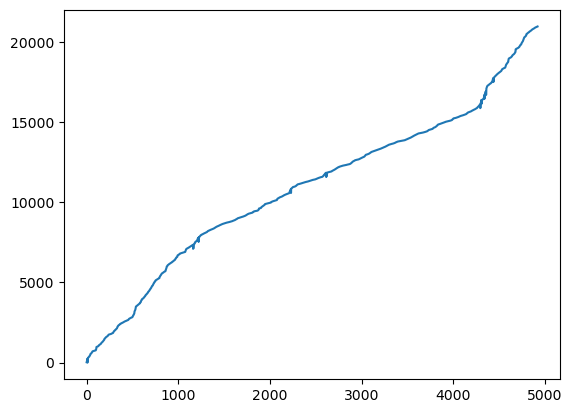

In [27]:
y = cdf["CID"].unique()
x = range(len(cdf["CID"].unique()))
plt.plot(x,y)

In [65]:
first = cdf["Group2"].searchsorted("LC3", side='right')
print(first)

TypeError: '<' not supported between instances of 'float' and 'str'

Determine Group2

In [86]:
CID_LAMP1 = cdf["CID"][cdf["C1"]=="LAMP1"].unique()
CID_LC3 = cdf["CID"][cdf["C1"]=="LC3"].unique()
cdf["Group2"]= np.nan
cdf["Group2"][cdf["CID"].isin(CID_LAMP1)] = "LAMP1"
cdf["Group2"][cdf["CID"].isin(CID_LC3)] = "LC3"
LAMP1df = cdf[cdf["Group2"]=="LAMP1"]
LC3df = cdf[cdf["Group2"]=="LC3"]
LC3df.head()
print(cdf.iloc[[35391]])

       Unnamed: 0   CID            S              V     C1       C2  radius  \
35391       35391  3408  2755.874024  108636.669022  LAMP1  aSyn_AB      14   

      Group2  
35391  LAMP1  


In [92]:
print(cdf.iloc[range(LAMP1df.index.min(),LC3df.index.min())])

       Unnamed: 0   CID            S              V        C1        C2  \
0               0    17   218.265756      30.308358  aSyn_GFP     LAMP1   
1               1    17   238.018789      19.809795     LAMP1  aSyn_GFP   
2               2    17   638.750087     175.218069  aSyn_GFP     LAMP1   
3               3    17   618.588724      99.761616     LAMP1  aSyn_GFP   
4               4    17   944.550370     496.376332  aSyn_GFP     LAMP1   
...           ...   ...          ...            ...       ...       ...   
35387       35387  3408  2658.135314  592926.014576  aSyn_GFP     LAMP1   
35388       35388  3408  2287.697189  666829.001705   aSyn_AB  aSyn_GFP   
35389       35389  3408  2857.297855  111138.166951   aSyn_AB     LAMP1   
35390       35390  3408  2616.883421  597501.679622     LAMP1  aSyn_GFP   
35391       35391  3408  2755.874024  108636.669022     LAMP1   aSyn_AB   

       radius Group2  
0           1  LAMP1  
1           1  LAMP1  
2           2  LAMP1  
3      

In [115]:
dic = {1:"FY",2:"FY",3:"TP",4:"TP",5:"X",6:"X"}
dfs = []
ID = 1
def reassign_df(base,df1, df2,ID,dfs,dic):
    i1min = df1.index.min()
    print(i1min)
    i1max = df1.index.max()
    
    i2min = df2.index.min()
    if np.isnan(i2min) == True:
        newdf = df1
        newdf["Group1"] = dic[ID]
        dfs.append(newdf)
        print(newdf["Group2"].unique())
        return dfs
    i2max = df2.index.max()
    newdf = base.iloc[i1min:i2min]
    newdf["Group1"] = dic[ID]
    print(newdf["Group2"].unique())
    df22 = df1[~df1.CID.isin(newdf.CID.values)]
    df1 = df2
    df2 = df22
    ID += 1
    dfs.append(newdf)
    reassign_df(base,df1, df2,ID,dfs,dic)
    return dfs
    
rdf = pd.concat(reassign_df(cdf,LAMP1df, LC3df,ID,dfs,dic))

rdf.head()
    

0
['LAMP1' nan]
35392
['LC3' nan]
63980
['LAMP1' nan]
114604
['LC3' nan]
154896
['LAMP1' nan]
222460
['LC3']


Unnamed: 0  CID           S           V        C1        C2  radius Group2  \
0           0   17  218.265756   30.308358  aSyn_GFP     LAMP1       1  LAMP1   
1           1   17  238.018789   19.809795     LAMP1  aSyn_GFP       1  LAMP1   
2           2   17  638.750087  175.218069  aSyn_GFP     LAMP1       2  LAMP1   
3           3   17  618.588724   99.761616     LAMP1  aSyn_GFP       2  LAMP1   
4           4   17  944.550370  496.376332  aSyn_GFP     LAMP1       3  LAMP1   

  Group1  
0     FY  
1     FY  
2     FY  
3     FY  
4     FY

In [204]:
rdf.to_csv(os.path.join(basedir,"Ripley_FINAL.csv"))

In [121]:
rdf["M"] = (rdf["radius"]**2)*math.pi
rdf["S_wave"] = (rdf["S"]-rdf["M"])/rdf["V"]
rdf.head()

Unnamed: 0  CID           S           V        C1        C2  radius Group2  \
0           0   17  218.265756   30.308358  aSyn_GFP     LAMP1       1  LAMP1   
1           1   17  238.018789   19.809795     LAMP1  aSyn_GFP       1  LAMP1   
2           2   17  638.750087  175.218069  aSyn_GFP     LAMP1       2  LAMP1   
3           3   17  618.588724   99.761616     LAMP1  aSyn_GFP       2  LAMP1   
4           4   17  944.550370  496.376332  aSyn_GFP     LAMP1       3  LAMP1   

  Group1          M     S_wave  
0     FY   3.141593   7.097849  
1     FY   3.141593  11.856619  
2     FY  12.566371   3.573739  
3     FY  12.566371   6.074705  
4     FY  28.274334   1.845930

In [125]:
sdf.head()

label  bbox-0  bbox-1  bbox-2  bbox-3  intensity_mean  Area  centroid-0  \
0      6      49      59      64      72      266.389313   131   56.419847   
1     12      96     100     106     110      338.882353    51  100.882353   
2     17     120     113     128     126      381.865169    89  123.730337   
3     18     127      88     133      94      384.321429    28  129.214286   
4     19     146     141     152     151      432.285714    49  148.816327   

   centroid-1  perimeter  Include  CID  SID   Channel  
0   65.083969  43.213203     True   17    6  aSyn_GFP  
1  104.686275  27.798990     True   17   12  aSyn_GFP  
2  119.280899  33.313708     True   17   17  aSyn_GFP  
3   90.571429  17.656854     True   17   18  aSyn_GFP  
4  145.408163  24.485281     True   17   19  aSyn_GFP

In [4]:
def get_E(RAD,p,a,b,Omega,n1):
    areaB = np.array([math.pi*(r**2) for r in RAD])
    PC = (p*Omega)/(2*n1)
    erf1 = np.array([math.erf((r-a)/math.sqrt(2*b)) for r in RAD])
    erf2 = np.array([math.erf((-r-a)/math.sqrt(2*b)) for r in RAD])
    return areaB+(PC*(erf1-erf2))


In [8]:
rdf = pd.read_csv(os.path.join(basedir,"Ripley_FINAL.csv"))
print(len(rdf))

310016


In [10]:


def get_parametric():
    rdf = pd.read_csv(os.path.join(basedir,"Ripley_FINAL.csv"))
    sdf = pd.read_csv(os.path.join(basedir,"SpotsInfo.csv"))
    dfs = []
    CIDs = []
    if os.path.exists(os.path.join(basedir,"Ripley_parametric.csv")) == True:
        oldrdf = pd.read_csv(os.path.join(basedir,"Ripley_parametric.csv"))
        dfs = [oldrdf]
        CIDs = np.array(oldrdf["CID"].unique())
    for CID in rdf["CID"].unique():
        if CID in CIDs:
            continue
        for c1 in rdf["C1"][rdf["CID"]==CID].unique():
            for c2 in rdf["C2"][rdf["CID"]==CID][rdf["C1"]==c1].unique():
                tempdf = rdf[rdf["CID"]==CID][rdf["C1"]==c1][rdf["C2"]==c2]
                Xn = len(sdf[sdf["CID"]==CID][sdf["Channel"]==c1])
                popt, pcov = curve_fit(lambda RAD,p,a,b,Omega: get_E(RAD,p,a,b,Omega,Xn), tempdf["radius"], tempdf["S"], bounds=(0,np.inf),maxfev=5000)
                tempdf["p"] = popt[0]
                tempdf["a"] = popt[1]
                tempdf["b"] = popt[2]
                tempdf["O"] = popt[3]
                print(tempdf["Group1"].unique(),tempdf["Group2"].unique())
                dfs.append(tempdf)
        newdf = pd.concat(dfs)
        newdf.to_csv(os.path.join(basedir,"Ripley_parametric.csv"))
    return
                
paradf = get_parametric()
#paradf.head()

1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']
['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['FY'] ['LC3']
['FY'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']
['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']
['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['TP'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] 

1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] [nan]


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']
['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LAMP1']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X']

1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


 ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']

1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']
['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


1869456764.py (15): Boolean Series key will be reindexed to match DataFrame index.
1869456764.py (16): Boolean Series key will be reindexed to match DataFrame index.


['X'] ['LC3']


In [ ]:
rpdf = 

In [136]:
rdf.groupby(["C1","C2",'Group1',"Group2","radius"]).median()

Unnamed: 0      CID            S  \
C1       C2      Group1 Group2 radius                                     
LAMP1    aSyn_AB FY     LAMP1  1          18835.0   1773.5   360.460744   
                               2          18841.0   1773.5  1020.952087   
                               3          18847.0   1773.5  1805.810041   
                               4          18853.0   1773.5  2500.354085   
                               5          18859.0   1773.5  2984.907686   
...                                           ...      ...          ...   
aSyn_GFP aSyn_AB X      LC3    10        267804.0  14502.5  5315.692527   
                               11        267810.0  14502.5  5916.056488   
                               12        267816.0  14502.5  6401.044067   
                               13        267822.0  14502.5  6871.778285   
                               14        267828.0  14502.5  7339.046955   

                                                  V           M    S_wave  
C1       C2      Group1 Group2 radius                                      
LAMP1    aSyn_AB FY     LAMP1  1         266.431919    3.141593  0.763604  
                               2        2111.658252   12.566371  0.344991  
                               3        6642.696374   28.274334  0.168200  
                               4       13245.083590   50.265482  0.114922  
                               5       24766.343995   78.539816  0.079734  
...                                             ...         ...       ...  
aSyn_GFP aSyn_AB X      LC3    10      36644.075290  314.159265  0.078587  
                               11      47260.753356  380.132711  0.070796  
                               12      59138.374006  452.389342  0.060131  
                               13      74255.028970  530.929158  0.052697  
                               14      89995.504321  615.752160  0.047253  

[504 rows x 6 columns]

59086749.py (2): Boolean Series key will be reindexed to match DataFrame index.


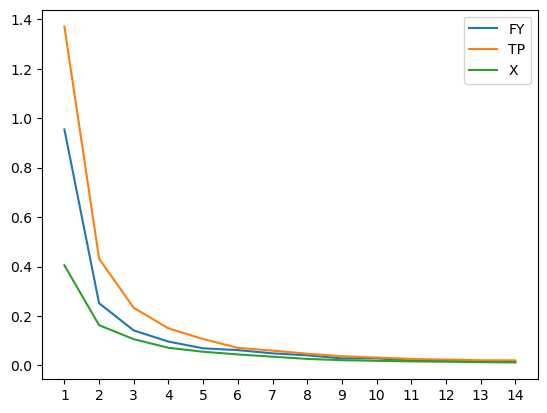

     R         S   G           M          Ssd
0    1  0.954930  FY    3.141593  1788.481851
1    2  0.251673  FY   12.566371   314.450008
2    3  0.141471  FY   28.274334    79.411534
3    4  0.096350  FY   50.265482    32.380500
4    5  0.069152  FY   78.539816    15.608422
5    6  0.061894  FY  113.097336     8.145463
6    7  0.048796  FY  153.938040     5.867331
7    8  0.040815  FY  201.061930     3.039570
8    9  0.028513  FY  254.469005     3.758941
9   10  0.028648  FY  314.159265     1.308288
10  11  0.019597  FY  380.132711     1.052192
11  12  0.018890  FY  452.389342     0.713190
12  13  0.015136  FY  530.929158     0.545993
13  14  0.013923  FY  615.752160     0.667556
14   1  1.371223  TP    3.141593  1088.924188
15   2  0.431903  TP   12.566371   100.397726
16   3  0.232933  TP   28.274334    30.786847
17   4  0.149942  TP   50.265482    11.744353
18   5  0.106747  TP   78.539816     5.365116
19   6  0.071104  TP  113.097336     2.820091
20   7  0.059913  TP  153.938040  

In [203]:
def plot_ripley_S(rdf,c1,c2,g2):
    olddf = rdf[rdf["Group2"]==g2][rdf["C1"]==c1][rdf["C2"]==c2]
    group = olddf.groupby(["Group1","radius"])
    S = np.array(group.median()["S_wave"])
    Ssd = np.array(group.std()["S_wave"])
    M = np.array(group.median()["M"])
    V = np.array(group.median()["V"])
    MV = V+M
    K = np.array(list(group.groups.keys()))
    R = K[:,1]
    G = K[:,0]
    df= pd.DataFrame(data={"R":R,"S":S,"G":G,"M":M,"Ssd":Ssd})
    mi = 0
    for g in df["G"].unique():
        y = df["S"][df["G"]==g]
        x = df["R"][df["G"]==g]
        yerr = df["Ssd"][df["G"]==g]*2
        plt.plot(x,y,label=g)
        #plt.errorbar(x,y,yerr=yerr)
        plt.legend()
        if mi == 0:
            yt = df["M"][df["G"]==g]
            xt = df["R"][df["G"]==g]
            #plt.plot(xt,yt,label="Mean")
            #plt.legend()
            mi= mi+1
    plt.show()
    return df

print(plot_ripley_S(rdf,"aSyn_GFP","LC3","LC3"))

## 5. Colocalisation
### 5.1 Pixel-based Colocalisation
#### 5.1.1 Pearson Correlation Coefficient

In [ ]:
def pearsoncorr(X, Y, idf, cdf, CID, basedir):
    rC = cdf[cdf["CID"]== CID]
    label = int(rC["label"])
    NDID = int(rC["NDID"])
    rI = idf[idf["NDID"] == NDID]
    celllabel = tiff.imread(os.path.join(os.path.join(basedir, "Labels"), str(int(rI["ID"][rI["Channel"]=="GFP"]))+".tif"))
    nucleilabel = tiff.imread(os.path.join(os.path.join(basedir, "Labels"), str(int(rI["ID"][rI["Channel"]=="DAPI"]))+".tif"))
    X_i = tiff.imread(os.path.join(os.path.join(basedir, "Images"), str(int(rI["ID"][rI["Channel"]==X]))+".tif"))[0,:,:]
    Y_i = tiff.imread(os.path.join(os.path.join(basedir, "Images"), str(int(rI["ID"][rI["Channel"]==Y]))+".tif"))[0,:,:]
    X_c = crop(X_i,label,cdf)
    Y_c = crop(Y_i,label,cdf)
    c_c = crop(celllabel,label,cdf)
    n_c = crop(nucleilabel,label,cdf)
    binary = np.zeros(n_c.shape, dtype = np.uint8)
    binary[c_c == label] = 1
    binary[n_c == label] = 0
    msk_indices = np.nonzero(binary)
    X_m = X_c[msk_indices[0],msk_indices[1]].flatten()
    Y_m = Y_c[msk_indices[0],msk_indices[1]].flatten()
    p = np.corrcoef(X_m, Y_m)
    return p

#p = pearsoncorr("GFP", "568_2", idf, dfC, CID, basedir)
#print(p[0,1])

In [ ]:
def rotatepearson(idf, cdf, CID, basedir):
    rcomb = pd.merge(idf, cdf, on="NDID" , how='inner')
    rC = rcomb[rcomb["CID"]== CID]
    channels = []
    for c1 in rC["Channel"].unique():
        for c2 in rC["Channel"].unique():
            channels.append((c1,c2))
    for c in channels:
        if c[0]==c[1] or "DAPI" in c:
            continue
        cn = "Pearson_"+str(c[0])+"_vs_"+str(c[1])
        cdf[cn] = pearsoncorr(c[0], c[1], idf, cdf, cdf["CID"], basedir)[0,1]
    return cdf

#dfC = rotatepearson(idf, dfC, CID, basedir)
#dfC.head()

### 5.1.2 Manders

In [ ]:
def manders(X, Y, idf, cdf, CID, basedir):
    rC = cdf[cdf["CID"]== CID]
    label = int(rC["label"])
    NDID = int(rC["NDID"])
    rI = idf[idf["NDID"] == NDID]
    X_i = tiff.imread(os.path.join(os.path.join(basedir, "Spots"), str(int(rI["ID"][rI["Channel"]==X]))+".tif"))
    Y_i = tiff.imread(os.path.join(os.path.join(basedir, "Spots"), str(int(rI["ID"][rI["Channel"]==Y]))+".tif"))
    binaryx = X_i > 0
    
    binaryy = Y_i > 0
    binaryxy = binaryx & binaryy
    x = np.sum(binaryx)
    u = np.sum(binaryxy)
    if 0 in [x, u]:
        return 0
    else:
        M = x/u
        return M

#print(manders("GFP", "568_2", idf, dfC, CID, basedir))

In [ ]:
def rotatemanders(idf, cdf, CID, basedir):
    rcomb = pd.merge(idf, cdf, on="NDID" , how='inner')
    rC = rcomb[rcomb["CID"]== CID]
    channels = []
    for c1 in rC["Channel"].unique():
        for c2 in rC["Channel"].unique():
            channels.append((c1,c2))
    for c in channels:
        if c[0]==c[1] or "DAPI" in c:
            continue
        cn = "Manders_"+str(c[0])+"_vs_"+str(c[1])
        cdf[cn] = manders(c[0], c[1], idf, cdf, cdf["CID"], basedir)
    return cdf

#dfC = rotatemanders(idf, dfC, CID, basedir)
#dfC.head()

### 5.2 Object-based Colocalisation
#### 5.2.1 Difference matrix

In [ ]:
def calculatediff(x, y, idf, cdf, sdf, CID, basedir):
    rcomb = pd.merge(idf, cdf, on="NDID" , how='inner')
    rC = rcomb[rcomb["CID"]== CID]
    IDx = int(rC["ID"][rC["Channel"]==x])
    IDy = int(rC["ID"][rC["Channel"]==y]) 
    SIDs = np.array(sdf["SID"][sdf["ID"]==IDy].values)
    X1 = np.array(sdf["centroid-0"][sdf["ID"]==IDx].values, ndmin = 2).T
    X2 = np.array(sdf["centroid-1"][sdf["ID"]==IDx].values, ndmin = 2).T
    X = np.stack([X2.T,X1.T]).reshape(2,-1).T
    Y1 = np.array(sdf["centroid-0"][sdf["ID"]==IDy].values, ndmin = 2)
    Y2 = np.array(sdf["centroid-1"][sdf["ID"]==IDy].values, ndmin = 2)
    Y = np.stack([Y2,Y1]).reshape(2,-1).T
    D1 = np.matmul(X1, np.ones(Y1.shape))-np.matmul(np.ones(X1.shape),Y1)
    D2 = np.matmul(X2, np.ones(Y2.shape))-np.matmul(np.ones(X2.shape),Y2)
    D = np.sqrt(D1**2 + D2**2)
    return D, SIDs, X, Y

#print(calculatediff("GFP", "568_2", idf, dfC,df, CID, basedir)[0].shape)

#### 5.2.2 Nearest neigbor

In [ ]:
def nearest_neighbor(idf, cdf, sdf, CID, basedir):
    rcomb = pd.merge(idf, cdf, on="NDID" , how='inner')
    rC = rcomb[rcomb["CID"]== CID]
    rC = rC.drop(rC[rC["Channel"] == "DAPI"].index)
    SIDs = sdf["SID"][sdf["ID"].isin(rC["ID"].unique())]
    nndf = pd.DataFrame()
    nndf["SID"] = SIDs
    for c1 in rC["Channel"].unique():
        m = []
        ID = []
        for c2 in rC["Channel"].unique():
            D, SID, X, Y = calculatediff(c2, c1, idf, cdf, sdf, CID, basedir)
            if int(D.shape[1]) == 0 or c1 == c2:
                mins = np.empty(D.shape[0])
                mins[:] = np.nan
                m.append(mins)
                iD = np.empty(D.shape[0])
                iD[:] = np.nan
                ID.append(iD)
            else:
                mins = np.amin(D, axis = 1)
                m.append(mins)
                iDi = np.argmin(D, axis = 1)
                iD = np.take_along_axis(SID, iDi, axis = 0)
                ID.append(iD)
        cn = "NN_"+str(c1)
        m = np.concatenate(m)
        ID = np.concatenate(ID)
        nndf[cn+"_len"] = m
        nndf[cn+"_ID"] = ID
    return nndf

#sdf = nearest_neighbor(idf, dfC, df, CID, basedir)
#sdf.head()

#### 5.2.3 Ripley's K-function
Ripleys K-function will be used as the primary colocalisation metric for this experiment. (**insert description**)

It allows for a  simple boundary correction term. First the distance from each pint to the closest edge needs to be determined:

In [493]:
def correct_boundary(r,h):
    return 1/(1-((np.arccos(np.minimum(r,h)/r))/math.pi))

#r = 10
#bc = correct_boundary(r,h)
#print(bc)

In [470]:
def get_A12(X,r):
    XTree = KDTree(X)
    Dis = XTree.sparse_distance_matrix(XTree,2*r).toarray()
    Dis[Dis == 0] = 'nan'
    Xneighbors = (2*(r**2)*(np.arccos(Dis/(2*r))))-(Dis*np.sqrt(4*(r**2)-np.power(Dis,2))/2)
    A12 = np.nansum(Xneighbors,axis = 1)
    return A12

In [498]:
def get_S(X,Y,r,h,omega):
    treeX = KDTree(X)
    treeY = KDTree(Y)
    D = treeX.sparse_distance_matrix(treeY,r).toarray()
    D[D==0] = "nan"
    h = np.array(h)
    h = np.repeat(h,D.shape[1]).reshape(D.shape[1],-1).T
    CB = correct_boundary(D,h)
    return (omega/(D.shape[0]*D.shape[1]))*np.nansum(CB)

In [392]:
idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))

In [23]:
cdf.head()

Unnamed: 0  CID           S           V        C1        C2  radius
0           0   17  218.265756   30.308358  aSyn_GFP     LAMP1       1
1           1   17  238.018789   19.809795     LAMP1  aSyn_GFP       1
2           2   17  638.750087  175.218069  aSyn_GFP     LAMP1       2
3           3   17  618.588724   99.761616     LAMP1  aSyn_GFP       2
4           4   17  944.550370  496.376332  aSyn_GFP     LAMP1       3

In [526]:
def resegment(idf,sdf,basedir,model):
    cdf = pd.read_csv(os.path.join(basedir,"CellInfo.csv"))
    maxI = str(len(cdf["CID"].unique()))
    rdfs = []
    if os.path.exists(os.path.join(basedir,"Ripley.csv")) == True:
        trdf = pd.read_csv(os.path.join(basedir,"Ripley.csv"))
        rdfs.append(trdf)
        
        print(maxI+"/"+str(len(trdf["CID"].unique())))
        cdf = cdf[~cdf['CID'].isin(trdf["CID"].unique())]
    if "Omega" not in list(cdf.columns):
        cdf["Omega"] = cdf["Area_cell"] - cdf["Area_nucleus"]
        print(cdf.head())
    for NDID in cdf["NDID"].unique():
        DAPI_ID = int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="DAPI"])
        GFP_ID = int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="aSyn_GFP"])
        DAPI = getImage(idf, DAPI_ID, basedir)
        GFP = getImage(idf, GFP_ID, basedir)
        for CID in cdf["CID"][cdf["NDID"]==NDID].unique():
            CDF = cdf[cdf["CID"]==CID]
            print(CDF)
            SDF = sdf[sdf["CID"]==CID]
            sDAPI = DAPI[int(CDF["Stack"].values[0]),:,:]
            sGFP = GFP[int(CDF["Stack"].values[0]),:,:]
            #crop
            bbox0 = int(CDF["bbox-0"].values[0])
            bbox1 = int(CDF["bbox-1"].values[0])
            bbox2 = int(CDF["bbox-2"].values[0])
            bbox3 = int(CDF["bbox-3"].values[0])
            sDAPI = sDAPI[bbox0:bbox2,bbox1:bbox3]
            sGFP = sGFP[bbox0:bbox2,bbox1:bbox3]
            #segment nuclei + get h
            xlen = idf["xlen"][idf["ID"]==DAPI_ID].values[0]
            labelsN = segment_nuclei_slice(sDAPI, xlen, model)
            truelabel = labelsN[int(CDF["centroid-0_nucleus"].values[0])-bbox0,int(CDF["centroid-1_nucleus"].values[0])-bbox1]
            labelsN[labelsN != truelabel] = 0
            labelsN[labelsN == truelabel] = 1
            centroids = np.array([SDF["centroid-0"].values,SDF["centroid-0"].values]).T
            hN = KDTree(regionprops(labelsN)[0].coords).query(centroids)[0]
            #segment cytoplsm + get h
            if len(np.unique(sGFP)) < 3:
                continue
            t = threshold_multiotsu(sGFP)
            labelsN[sGFP < t[-1]] = 0
            labelsN[sGFP < t[0]] = 2
            elevation_map = sobel(sGFP)
            seg = watershed(elevation_map, labelsN)
            seg[seg == 1] = 0
            cdf.at[int(cdf.index[cdf['CID'] == CID].tolist()[0]), 'intensity_mean_cell'] = regionprops(seg,intensity_image=sGFP)[0].intensity_mean
            cdf.at[int(cdf.index[cdf['CID'] == CID].tolist()[0]), 'intensity_max_cell'] = regionprops(seg,intensity_image=sGFP)[0].intensity_max
            hC = KDTree(regionprops(seg)[0].coords).query(centroids)[0]
            
            # get h + Omega
            h = np.minimum(hN,hC)
            omega = int(CDF["Omega"].values[0])
            SDF["h"] = h
            #get b
            inv = np.invert(seg.astype('bool'))
            if len(np.unique(inv)) == 1:
                continue
            tree = KDTree(regionprops(inv.astype('uint8'))[0].coords)
            for r in range(1,15):
                sel = tree.query(centroids,k = 1000, distance_upper_bound = r)[0].T
                sel[sel == np.inf] = "nan"
                sel[sel == 0] = "nan"
                cb = correct_boundary(sel,h).T
                nSEL = np.count_nonzero(~np.isnan(cb), axis= 1)+1
                areaH = np.array(tree.query_ball_point(centroids,r=r,return_length=True))
                b = areaH*(np.nansum(cb, axis = 1)/nSEL)
                SDF["b"+str(r)] = b
                for c1 in SDF["Channel"].unique():
                    SDF1 = SDF[SDF["Channel"]==c1]
                    X = np.array([SDF1["centroid-0"].values,SDF1["centroid-0"].values]).T
                    A12 = get_A12(X,r)
                    for c2 in SDF["Channel"].unique():
                        if c2 == c1:
                            continue
                        else:
                            SDF2 = SDF[SDF["Channel"]==c2]
                            Y = np.array([SDF2["centroid-0"].values,SDF2["centroid-0"].values]).T
                            Xn = X.shape[0]
                            Yn = Y.shape[0]
                            M = (r**2)*math.pi
                            B = SDF1["b"+str(r)].values
                            AB = np.sum(B+A12)
                            V = ((omega/(Yn*(Xn**2)))*AB)-(((math.pi**2)*(r**4))/Yn)
                            #get S
                            S = get_S(X,Y,r,SDF1["h"].values,omega)
                            data = {"CID":[CID], "S":[S], "V":[V], "C1":[c1], "C2":[c2], "radius":[r]}
                            rdfs.append(pd.DataFrame(data=data))
            rdf = pd.concat(rdfs, ignore_index = True)
            print(maxI+"/"+str(len(rdf["CID"].unique())))
            rdfs = [rdf]
            rdf.to_csv(os.path.join(basedir,"Ripley.csv"),index=False)
            cdf.to_csv(os.path.join(basedir,"CellInfo.csv"),index=False)
    return "DONE"

print(resegment(idf,sdf,basedir,model))



9740/4919
<ND2File at 0x23a0064adc0: 'FY_LAMP1 - Deconvolved 20 iterations, Type Richardson-Lucy.nd2.nd2' uint16: {'P': 30, 'Z': 11, 'C': 5, 'Y': 2048, 'X': 2048}>
<ND2File at 0x23a00a7c040: 'FY_LAMP1 - Deconvolved 20 iterations, Type Richardson-Lucy.nd2.nd2' uint16: {'P': 30, 'Z': 11, 'C': 5, 'Y': 2048, 'X': 2048}>
   Unnamed: 0.8  Unnamed: 0.7  Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  \
0             0             0             0             0             0   

   Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  label  ...  \
0             0            11            11          11      2  ...   

   Area_nucleus  centroid-0_nucleus  centroid-1_nucleus       N:C  Include  \
0         19879         1539.593541          363.165049  0.837434     True   

   NDID  CID  Stack  Omega  intensity_max_cell  
0     2  236      0   3859               113.0  

[1 rows x 29 columns]
1/1 [==============================] - 0s 116ms/step
9740/4919
   Unnamed: 0.8  Unnamed: 0.7  Unnamed: 0.6  Un

KeyboardInterrupt: 

In [356]:
def get_h(x, CID, basedir):
    cb = []
    nb = []
    with open(os.path.join(basedir,'cytoplasm.pickle'), 'rb') as handle:
            cb = pickle.load(handle)
    with open(os.path.join(basedir,'nucleus.pickle'), 'rb') as handle:
            nb = pickle.load(handle)
    if CID not in cb.keys() or CID not in nb.keys():
        return "EXIT", "EXIT"
    boundary = np.concatenate((np.array(cb[CID]), np.array(nb[CID])), axis = 0)
    return KDTree(boundary).query(x)[0], "Ok"

sinfo = os.path.join(basedir, "SpotsInfo.csv")
df = pd.read_csv(sinfo)
df.head()
chanGFP = "aSyn_GFP"
CID = 848
x = np.array([df["centroid-0"][df["Channel"]==chanGFP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanGFP][df["CID"]==CID]]).T
#h = get_h(x, CID, basedir)[0]
print(h)

EXIT


Afterwards the boundary correction term can be calculated. THe function takes in the smallest distance to the edge and the radius of the ball. If h < r the boundary correction term is >1:

NameError: name 'bc' is not defined

In [ ]:
def get_b(x,r,cdf,CID,basedir):
    coords = get_coords(CID,cdf)
    omega = coords.shape[0]
    co = KDTree(coords).sparse_distance_matrix(KDTree(x),r).toarray().T
    co[co == 0] = "nan"
    area = np.count_nonzero(co, axis = 1)
    h,error = get_h(x, CID, basedir)
    if error == "EXIT":
        return "EXIT","EXIT","EXIT"
    h = h.reshape(-1,1)
    f = correct_boundary(co,h)
    b = np.nansum(f,axis = 1)*area
    return b, omega,"ok"

max_r = 40
chanGFP = "aSyn_GFP"
CID = 17
x = np.array([df["centroid-0"][df["Channel"]==chanGFP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanGFP][df["CID"]==CID]]).T
chanLAMP = "LAMP1"
CID = 17
y = np.array([df["centroid-0"][df["Channel"]==chanLAMP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanLAMP][df["CID"]==CID]]).T
r = 10
#print(get_b(x,r,dfC,CID,basedir))

In [13]:
dfC.head()

NameError: name 'dfC' is not defined

In [359]:
cdf.head()

Unnamed: 0  label  bbox-0  bbox-1  bbox-2  bbox-3  intensity_mean_cell  \
0           0     17      99     565     907     973           495.045658   
1           1     45     175     566     787     952           526.039749   
2           2     75     177     566     784     951           535.720267   
3           3     95     175     566     783     949           537.498256   
4           4    124     175     574     783     949           539.612583   

   Area_cell  centroid-0_cell  centroid-1_cell  intensity_mean_nucleus  \
0     104166       446.693518       737.171409              191.458442   
1      96531       448.821363       736.767215              193.978046   
2      95709       448.497748       737.467594              196.422438   
3      96069       445.413245       736.511070              199.253764   
4      95636       445.981900       737.693348              201.755817   

   Area_nucleus  centroid-0_nucleus  centroid-1_nucleus       N:C  Include  \
0         34903          436.491963          696.746354  0.335071     True   
1         33844          434.261848          696.167267  0.350602     True   
2         33444          432.993153          695.770542  0.349434     True   
3         32873          431.763636          695.060323  0.342181     True   
4         32447          430.195488          694.871144  0.339276     True   

   NDID  CID  Stack  
0     0   17      0  
1     0   45      1  
2     0   75      2  
3     0   95      3  
4     0  124      4

<ND2File at 0x23a0e6d9400: 'FY_LAMP1 - Deconvolved 20 iterations, Type Richardson-Lucy.nd2.nd2' uint16: {'P': 30, 'Z': 11, 'C': 5, 'Y': 2048, 'X': 2048}>
before rescale
before pred
1/1 [==============================] - 0s 47ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 31ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 40ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 31ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 47ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 38ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 47ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [==============================] - 0s 31ms/step
before rescale2
[0 1]
before rescale
before pred
1/1 [======

Finally the asymmetric ripley function is implemented:

ValueError: x and y must have same first dimension, but have shapes (40,) and (0,)

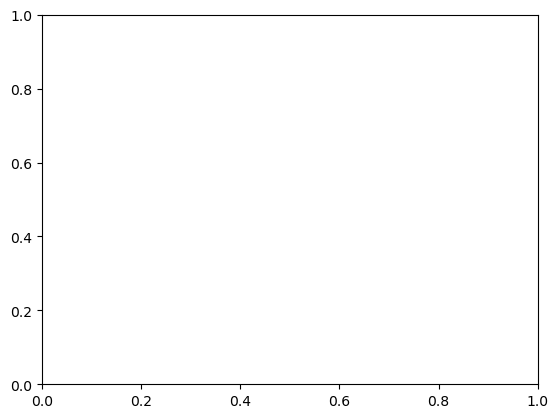

In [334]:
def get_S(x,y,r,CID,cdf,basedir):
    treeX = KDTree(x)
    treeY = KDTree(y)
    D = treeX.sparse_distance_matrix(treeY,r).toarray()
    D[D==0] = "nan"
    h, error = get_h(x, CID, basedir)
    if error == "EXIT":
        return "EXIT","EXIT"
    h = np.array(h)
    print(h)
    h = np.repeat(h,D.shape[1]).reshape(D.shape[1],-1).T
    CB = correct_boundary(D,h)
    area = int(cdf.loc[cdf["CID"]==CID,["Area_cell"]].values - cdf.loc[cdf["CID"]==CID,["Area_nucleus"]].values)
    return (area/(D.shape[0]*D.shape[1]))*np.nansum(CB) , "Ok"

max_r = 40
chanGFP = "aSyn_GFP"
CID = 17
x = np.array([df["centroid-0"][df["Channel"]==chanGFP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanGFP][df["CID"]==CID]]).T
chanLAMP = "LAMP1"
CID = 17
y = np.array([df["centroid-0"][df["Channel"]==chanLAMP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanLAMP][df["CID"]==CID]]).T
Sarr = []
Rarr = []
for r in range(max_r):
    Rarr.append(r)
    #Sarr.append(get_S(x,y,r,CID,dfC,basedir))
plt.plot(np.array(Rarr),np.array(Sarr))

Next for the statistics calculation we need the mean and the variance. Calculation of the mean is quite simple:

In [83]:
def get_m(r):
    return (r**2)*math.pi

#print(get_m(10))

The variance is more complicated to calculate. First of all a function is implemented that loads the coordinates of the cell into tree:

In [354]:
def get_coords(CID,cdf):
    coords = []
    with open(os.path.join(basedir,'sampling.pickle'), 'rb') as handle:
            coords = pickle.load(handle)[CID]
    sub = np.array([cdf["bbox-0"][cdf["CID"] == CID],cdf["bbox-1"][cdf["CID"] == CID]]).reshape(1,2)
    return np.subtract(coords,sub)

CID = 848
coords = get_coords(CID,pd.read_csv(os.path.join(basedir, "CellInfo.csv")))
print(coords)

KeyError: 848

In [86]:
def get_A12(X,r):
    XTree = KDTree(X)
    Dis = XTree.sparse_distance_matrix(XTree,2*r).toarray()
    Dis[Dis == 0] = 'nan'
    Xneighbors = (2*(r**2)*(np.arccos(Dis/(2*r))))-(Dis*np.sqrt(4*(r**2)-np.power(Dis,2))/2)
    A12 = np.nansum(Xneighbors,axis = 1)
    return A12

max_r = 40
chanGFP = "aSyn_GFP"
CID = 17
x = np.array([df["centroid-0"][df["Channel"]==chanGFP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanGFP][df["CID"]==CID]]).T
chanLAMP = "LAMP1"
CID = 17
y = np.array([df["centroid-0"][df["Channel"]==chanLAMP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanLAMP][df["CID"]==CID]]).T
r = 10
#print(get_A12(x,r))

In [183]:
def get_VAR(x,y,r,cdf,CID,basedir):
    B, Omega, error = get_b(x,r,cdf,CID,basedir)
    if error == "EXIT":
        return "EXIT","EXIT","EXIT"
    A12 = get_A12(x,r)
    AB = np.sum(B+A12)
    Xn = x.shape[0]
    Yn = y.shape[0]
    VAR = ((Omega/(Yn*(Xn**2)))*AB)-(((math.pi**2)*(r**4))/Yn)
    return VAR, Omega,"ok"

max_r = 40
chanGFP = "aSyn_GFP"
CID = 17
x = np.array([df["centroid-0"][df["Channel"]==chanGFP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanGFP][df["CID"]==CID]]).T
chanLAMP = "LAMP1"
CID = 17
y = np.array([df["centroid-0"][df["Channel"]==chanLAMP][df["CID"]==CID],df["centroid-1"][df["Channel"]==chanLAMP][df["CID"]==CID]]).T
r = 10
#print(get_VAR(x,y,r,dfC,CID,basedir))

In [88]:
def get_S_wave(S,my,var):
    S_wave = (S-my)/(np.sqrt(var))
    return S_wave

S = get_S(x,y,r,CID,dfC,basedir)
my = get_m(r)
var, Omega = get_VAR(x,y,r,dfC,CID,basedir)
#S_wave = get_S_wave(S,my,var)
print(S_wave)

NameError: name 'dfC' is not defined

In [7]:
idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))

print(len(cdf))

8395


In [351]:
cb = []
nb = []
with open(os.path.join(basedir,'sampling.pickle'), 'rb') as handle:
        cb = pickle.load(handle)
with open(os.path.join(basedir,'nucleus.pickle'), 'rb') as handle:
        nb = pickle.load(handle)
print(np.unique(np.isin(np.unique(cdf["CID"].unique()),cb.keys())))
print(np.unique(np.isin(np.unique(cdf["label"].unique()),nb.keys())))
print(cb.keys())

[False]
[False]
dict_keys([36, 37, 34, 35, 32, 30, 31, 28, 29, 26, 24, 22, 20, 21, 8, 19, 2, 7, 33, 27, 23, 17, 18, 14, 16, 11, 13, 6, 9, 10, 4, 5, 66, 67, 54, 55, 62, 49, 50, 51, 43, 45, 46, 40, 25, 3, 81, 84, 72, 74, 63, 64, 53, 44, 47, 12, 42, 38, 15, 39, 109, 110, 113, 114, 115, 116, 119, 98, 99, 102, 103, 105, 107, 108, 88, 89, 92, 95, 96, 97, 77, 78, 79, 82, 85, 86, 87, 71, 73, 75, 76, 56, 58, 60, 65, 48, 52, 41, 70, 61, 57, 155, 161, 140, 143, 123, 127, 138, 112, 122, 80, 68, 69, 59, 90, 104, 93, 94, 83, 154, 124, 187, 190, 196, 167, 170, 147, 151, 129, 132, 137, 111, 101, 162, 163, 173, 174, 146, 150, 156, 158, 130, 131, 134, 118, 126, 100, 106, 219, 223, 201, 205, 182, 186, 166, 141, 148, 128, 153, 157, 152, 139, 160, 164, 165, 168, 169, 144, 145, 149, 133, 135, 136, 142, 117, 120, 121, 91, 203, 172, 125, 181, 183, 184, 185, 189, 193, 194, 195, 171, 176, 177, 159, 198, 202, 178, 221, 225, 226, 228, 230, 232, 234, 236, 208, 209, 210, 211, 179, 241, 247, 214, 231, 200, 212, 213,

In [347]:
cdf.head()

Unnamed: 0  label  bbox-0  bbox-1  bbox-2  bbox-3  intensity_mean_cell  \
0           0     17      99     565     907     973           495.045658   
1           1     45     175     566     787     952           526.039749   
2           2     75     177     566     784     951           535.720267   
3           3     95     175     566     783     949           537.498256   
4           4    124     175     574     783     949           539.612583   

   Area_cell  centroid-0_cell  centroid-1_cell  intensity_mean_nucleus  \
0     104166       446.693518       737.171409              191.458442   
1      96531       448.821363       736.767215              193.978046   
2      95709       448.497748       737.467594              196.422438   
3      96069       445.413245       736.511070              199.253764   
4      95636       445.981900       737.693348              201.755817   

   Area_nucleus  centroid-0_nucleus  centroid-1_nucleus       N:C  Include  \
0         34903          436.491963          696.746354  0.335071     True   
1         33844          434.261848          696.167267  0.350602     True   
2         33444          432.993153          695.770542  0.349434     True   
3         32873          431.763636          695.060323  0.342181     True   
4         32447          430.195488          694.871144  0.339276     True   

   NDID  CID  Stack  
0     0   17      0  
1     0   45      1  
2     0   75      2  
3     0   95      3  
4     0  124      4

In [212]:
cdf[cdf.index.duplicated()]

Empty DataFrame
Columns: [label, bbox-0, bbox-1, bbox-2, bbox-3, intensity_mean_cell, Area_cell, centroid-0_cell, centroid-1_cell, intensity_mean_nucleus, Area_nucleus, centroid-0_nucleus, centroid-1_nucleus, N:C, Include, NDID, CID, Stack]
Index: []

In [327]:
def ripley(c1,c2, x, y, stepsize,CID, cdf, basedir):
    data = {}
    for r in range(10):
        S, error1 = get_S(x,y,r,CID,cdf,basedir)
        if error1 == "EXIT":
            return "EXIT","EXIT"
        data[str(c1)+"__"+str(c2)+"__S__"+str(r)] = [S]
        data[str(c1)+"__"+str(c2)+"__M__"+str(r)] = [get_m(r)]
        V,O,error2 = get_VAR(x,y,r,cdf,CID,basedir)
        if error2 == "EXIT":
            return "EXIT","EXIT"
        data[str(c1)+"__"+str(c2)+"__V__"+str(r)] = [V]
    newdf = pd.DataFrame(data = data)
    return newdf,"ok"

In [76]:
sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))

In [332]:
def get_ripley_cell(sdf,cdf, CID, basedir, max_r):
    idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
    xlen = float(np.unique(idf.loc[idf["NDID"] == int(cdf["NDID"].loc[cdf["CID"] == CID].unique()), ["xlen"]].values))
    stepsize = 1
    SDF = sdf.loc[sdf["CID"]==CID]
    dfs = []
    for c1 in SDF["Channel"].unique():
        
        x = np.array([SDF["centroid-0"].loc[SDF["Channel"] == c1],SDF["centroid-1"].loc[SDF["Channel"] == c1]]).T
        
        for c2 in SDF["Channel"].unique():
            
            y = np.array([SDF["centroid-0"].loc[SDF["Channel"] == c2],SDF["centroid-1"].loc[SDF["Channel"] == c2]]).T
            rip,error = ripley(c1,c2, x, y, stepsize,CID, cdf, basedir)
            if error == "EXIT":
                return "EXIT","EXIT"
            dfs.append(rip)
    if dfs != []:
        complete = pd.concat(dfs,axis = 1)
        complete["CID"] = CID
        print(len(list(complete.columns)))
        return complete, "Fine"
    else:
        return "EXIT","EXIT"

cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
max_r = 1.5
CID = 17
newdf = get_ripley_cell(sdf,cdf, CID, basedir, max_r)
newdf.head()

[531.62298682 487.96563937 472.03511694 500.56733629 445.59553858
 478.53430402 453.13559658 419.75600078 466.71511134 498.97243856
 433.29134284 515.11518433 485.55037282 400.14347622 441.42924179
 534.94083317 384.41221237 406.26013506 490.80299143 430.78504916
 385.44559412 373.73922577 504.18176286 355.45857754 353.38541283
 335.29648973 351.86360994 351.05644133 335.27345293 346.48669171
 356.58479503 533.00347643 330.60563753 344.95867182 356.06557889
 335.58722103 356.7084809  325.65454089 379.32304054 314.7933116
 342.35632541 326.75733581 364.73201472 406.97151977 315.48108122
 393.94871651 340.61330414 280.07233551 308.59343212 339.69601238
 296.82993614 276.33889693 248.68069271 314.88590651 296.20109832
 263.79608154]


TypeError: cannot unpack non-iterable numpy.float64 object

In [12]:
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
c = list(cdf.columns)
cadj = []
for i in c:
    if "__"in i:
        cadj.append(i)
    if "Done"in i:
        cadj.append(i)
    if "Unnamed"in i:
        cadj.append(i)
print(cadj)
newcdffff = cdf.drop(cadj, axis=1)
print(newcdffff.head())
#newcdffff.to_csv(os.path.join(basedir, "CellInfo.csv"))

['Unnamed: 0']
   CID           S           V        C1        C2  radius
0   17  218.265756   30.308358  aSyn_GFP     LAMP1       1
1   17  238.018789   19.809795     LAMP1  aSyn_GFP       1
2   17  638.750087  175.218069  aSyn_GFP     LAMP1       2
3   17  618.588724   99.761616     LAMP1  aSyn_GFP       2
4   17  944.550370  496.376332  aSyn_GFP     LAMP1       3


In [ ]:
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))

In [284]:
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
cdf.head()

Unnamed: 0  label  bbox-0  bbox-1  bbox-2  bbox-3  intensity_mean_cell  \
0           0     17      99     565     907     973           495.045658   
1           1     45     175     566     787     952           526.039749   
2           2     75     177     566     784     951           535.720267   
3           3     95     175     566     783     949           537.498256   
4           4    124     175     574     783     949           539.612583   

   Area_cell  centroid-0_cell  centroid-1_cell  intensity_mean_nucleus  \
0     104166       446.693518       737.171409              191.458442   
1      96531       448.821363       736.767215              193.978046   
2      95709       448.497748       737.467594              196.422438   
3      96069       445.413245       736.511070              199.253764   
4      95636       445.981900       737.693348              201.755817   

   Area_nucleus  centroid-0_nucleus  centroid-1_nucleus       N:C  Include  \
0         34903          436.491963          696.746354  0.335071     True   
1         33844          434.261848          696.167267  0.350602     True   
2         33444          432.993153          695.770542  0.349434     True   
3         32873          431.763636          695.060323  0.342181     True   
4         32447          430.195488          694.871144  0.339276     True   

   NDID  CID  Stack  
0     0   17      0  
1     0   45      1  
2     0   75      2  
3     0   95      3  
4     0  124      4

In [338]:
def get_ripley_ALL(basedir, max_r):
    sdf = pd.read_csv(os.path.join(basedir, "SpotsInfo.csv"))
    cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
    maxID = 0
    IDs = cdf["CID"].unique()
    if os.path.exists(os.path.join(basedir, "Ripley.csv")) == True:
        rdf = pd.read_csv(os.path.join(basedir, "Ripley.csv"))
        maxID = rdf["CID"].max()
        IDs = cdf["CID"][cdf["CID"]>maxID].unique()
        print("Already done:")
        print(cdf["CID"][cdf["CID"]<=maxID].unique())
    max_ind = cdf.index.max()
    for CID in IDs:
        print(str(cdf.index[cdf["CID"]==CID][0])+"/"+str(max_ind)+": Started")
        rdf_new, exit = get_ripley_cell(sdf,cdf, CID, basedir, max_r)
        if exit == "EXIT":
            continue
        rdf_new.reset_index(drop=True)
        if os.path.exists(os.path.join(basedir, "Ripley.csv")) == True:
            rdf_old = pd.read_csv(os.path.join(basedir, "Ripley.csv"))
            rdf_old.reset_index(drop=True)
            rdf_save = pd.concat([rdf_old,rdf_new], ignore_index = True)
            rdf_save.to_csv(os.path.join(basedir, "Ripley.csv"))
        else:
            rdf_new.to_csv(os.path.join(basedir, "Ripley.csv"), index=False)
        print(str(cdf.index[cdf["CID"]==CID][0])+"/"+str(max_ind)+": Completed")
    return

get_ripley_ALL(basedir, max_r)

Already done:
[ 17  45  75  95 124 143 163 187 206 233   3 236 244 249 254]
15/15041: Started
16/15041: Started
17/15041: Started
18/15041: Started
19/15041: Started
20/15041: Started
21/15041: Started
22/15041: Started
23/15041: Started
24/15041: Started
25/15041: Started
26/15041: Started
27/15041: Started
28/15041: Started
29/15041: Started
30/15041: Started
31/15041: Started
32/15041: Started
33/15041: Started
34/15041: Started
35/15041: Started
36/15041: Started
37/15041: Started
38/15041: Started
39/15041: Started
40/15041: Started
41/15041: Started
42/15041: Started
43/15041: Started
44/15041: Started
45/15041: Started
46/15041: Started
47/15041: Started
48/15041: Started
49/15041: Started
50/15041: Started
51/15041: Started
52/15041: Started
53/15041: Started
54/15041: Started
55/15041: Started
56/15041: Started
57/15041: Started
58/15041: Started
59/15041: Started
60/15041: Started
61/15041: Started
62/15041: Started
63/15041: Started
64/15041: Started
65/15041: Started
66/150

KeyboardInterrupt: 

In [311]:
check = pd.read_csv(os.path.join(basedir, "Ripley.csv"))
print(check.head())

   aSyn_GFP__aSyn_GFP__S__0  aSyn_GFP__aSyn_GFP__M__0  \
0                       0.0                       0.0   

   aSyn_GFP__aSyn_GFP__V__0  aSyn_GFP__aSyn_GFP__S__1  \
0                       0.0                       0.0   

   aSyn_GFP__aSyn_GFP__M__1  aSyn_GFP__aSyn_GFP__V__1  \
0                  3.141593              7.925066e+06   

   aSyn_GFP__aSyn_GFP__S__2  aSyn_GFP__aSyn_GFP__M__2  \
0                       0.0                 12.566371   

   aSyn_GFP__aSyn_GFP__V__2  aSyn_GFP__aSyn_GFP__S__3  ...  \
0              3.088904e+07                       0.0  ...   

   LAMP1__LAMP1__S__7  LAMP1__LAMP1__M__7  LAMP1__LAMP1__V__7  \
0                 0.0           153.93804        3.396566e+08   

   LAMP1__LAMP1__S__8  LAMP1__LAMP1__M__8  LAMP1__LAMP1__V__8  \
0                 0.0           201.06193        4.421841e+08   

   LAMP1__LAMP1__S__9  LAMP1__LAMP1__M__9  LAMP1__LAMP1__V__9  CID  
0                 0.0          254.469005        5.594815e+08   95  

[1 rows x 271 

In [ ]:
plt.plot(R,S_wave)

In [ ]:
def get_E(RAD,p,a,b,Omega,n1):
    areaB = np.array([math.pi*(r**2) for r in RAD])
    PC = (p*Omega)/(2*n1)
    erf1 = np.array([math.erf((r-a)/math.sqrt(2*b)) for r in RAD])
    erf2 = np.array([math.erf((-r-a)/math.sqrt(2*b)) for r in RAD])
    return areaB+(PC*(erf1-erf2))

p = 1
a = 1
b = 1
n1 = x.shape[0]
E = get_E(Rarr,p,a,b,Omega,n1)
print(E)

In [ ]:
Xn = x.shape[0]
popt, pcov = curve_fit(lambda RAD,p,a,b: get_E(RAD,p,a,b,Omega,Xn), R, S, bounds=(0,np.inf))
plt.plot(R,S, 'b-', label='data')
plt.plot(R,get_E(R,popt[0],popt[1],popt[2],Omega,Xn),"r-",label='fit: p=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Radius')
plt.ylabel('S(r)')
plt.legend()
plt.show()

In [ ]:
Xn = x.shape[0]
plt.plot(R,S_wave, 'b-', label='data')
plt.plot(R,get_S_wave(get_E(R,popt[0],popt[1],popt[2],Omega,Xn),np.array(M),np.array(V)),"r-",label='fit: p=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Radius')
plt.ylabel('S(r)')
plt.legend()
plt.show()

In [ ]:
def correctboundary(D, SID, rC, sdf, basedir):
    c1 = sdf["centroid-0"][sdf["SID"].isin(SID)]
    c2 = sdf["centroid-1"][sdf["SID"].isin(SID)]
    label = int(rC["label"].unique()[0])
    celllabel = tiff.imread(os.path.join(os.path.join(basedir, "Labels"), str(int(rC["ID"][rC["Channel"]=="GFP"]))+".tif"))
    nucleilabel = tiff.imread(os.path.join(os.path.join(basedir, "Labels"), str(int(rC["ID"][rC["Channel"]=="DAPI"]))+".tif"))
    print(rC["bbox-0"][rC["label"]==label])
    c_c = crop(celllabel,label,rC[rC["Channel"]=="GFP"])
    n_c = crop(nucleilabel,label,rC[rC["Channel"]=="DAPI"])
    c_c[n_c > 0] = 0
    c_c[c_c != label] = 0
    BC = []
    for i in range(len(SID)):
        for j in range(len(D[0])):
            BCt = []
            rr, cc = disk((c1[0],c2[1]), D[0][j], shape = c_c.shape)
            circle = np.zeros(c_c.shape, dtype = np.uint8)
            circle[rr, cc] = 1
            areaC = regionprops(circle)[0].area
            union = circle
            union[c_c != label] = 0
            plt.imshow(union)
            unionT = pd.DataFrame(data = regionprops_table(union, properties=["area"]))
            areaU = unionT["area"].sum()
            ct = float(areaC)/float(areaU)
            BCt.append(ct)
        BC.append(BCt)
    BC = np.array(BC)
    print(BC.shape)
    return BC

def ripley(idf, cdf, sdf, CID, basedir, max_radius):
    rcomb = pd.merge(idf, cdf, on="NDID" , how='inner')
    rC = rcomb[rcomb["CID"]== CID]
    fC = rC.drop(rC[rC["Channel"] == "DAPI"].index)
    for c1 in fC["Channel"].unique():
        m = []
        ID = []
        for c2 in fC["Channel"].unique():
            D, SID = calculatediff(c2, c1, idf, cdf, sdf, CID, basedir)

            if int(D.shape[0]) == 0 or int(D.shape[1]) == 0 or c1 == c2:
                continue
            else:
                BC = correctboundary(D, SID, rC, sdf, basedir)
                print(BC)
                #for i in range(max_radius):
                continue
    return
ripley(idf, dfC, df, CID, basedir, 40)

                